In [1]:
import rosbag
import glob
import pdb
import numpy as np
import scipy.io as sio
import pickle
import matplotlib.pyplot as plt
from transformations import euler_from_quaternion

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.
/home/mpc/carla/PythonAPI/analysis/transformations.py:1926: UserWarning: No module named '_transformations'
  warnings.warn(str(err))


### Data Loading

In [2]:
save_ext = 'pkl'
files_to_process = glob.glob('../examples/bags/*.%s' % save_ext)

print('Found %d files to read: %s' % (len(files_to_process), files_to_process))

Found 44 files to read: ['../examples/bags/parking_p2_t2_e3_2019-11-04-16-39-13.pkl', '../examples/bags/parking_p2_t1_e9_2019-11-04-16-35-54.pkl', '../examples/bags/parking_p2_t1_e7_2019-11-04-16-35-13.pkl', '../examples/bags/parking_p2_t1_e0_2019-11-04-16-32-53.pkl', '../examples/bags/parking_p0_t0_e1_2019-11-04-14-22-22.pkl', '../examples/bags/parking_p0_t0_e0_2019-11-04-14-23-51.pkl', '../examples/bags/parking_p2_t2_e1_2019-11-04-16-37-56.pkl', '../examples/bags/parking_p1_t2_e1_2019-11-04-14-40-57.pkl', '../examples/bags/parking_p1_t2_e8_2019-11-04-14-44-50.pkl', '../examples/bags/parking_p2_t2_e0_2019-11-04-16-36-50.pkl', '../examples/bags/parking_p1_t1_e8_2019-11-04-14-37-56.pkl', '../examples/bags/parking_p2_t1_e1_2019-11-04-16-33-19.pkl', '../examples/bags/parking_p1_t2_e4_2019-11-04-14-42-44.pkl', '../examples/bags/parking_p1_t2_e0_2019-11-04-14-40-20.pkl', '../examples/bags/parking_p1_t1_e4_2019-11-04-14-36-16.pkl', '../examples/bags/parking_p2_t1_e2_2019-11-04-16-33-34.pkl',

In [3]:
file_num = 0
if save_ext == 'mat':
    res_dict = sio.loadmat(files_to_process[file_num], matlab_compatible=True) # TODO: starting with the first matfile for now
    
elif save_ext == 'pkl':
    res_dict = pickle.load(open(files_to_process[file_num],'rb'))
else:
    raise NotImplemented("Invalid extension.")
    
for k,v in res_dict.items():
    print(k)

vehicle_dict
intention_time_list
ego_info_dict
world_dict
ego_collision_list
ego_control_list
ego_gps_list
ego_odometry_list
vehicle_odometry_dict
vehicle_object_lists


### Time-Independent Data

In [4]:
# Print out intention signal times
print('Intention signaled at: ', res_dict['intention_time_list'])
print('\n')

# Print out vehicle ids and vehicle name
for k,v in res_dict['vehicle_dict'].items():
    print("%d: %s" %(k,v)) 
print('\n')

# Print out world settings
for k, v in res_dict['world_dict'].items():
    print(k, v)
print('\n')

Intention signaled at:  [1334.656914962]


1027: vehicle.tesla.model3_hero
1033: vehicle.mercedes-benz.coupe_autopilot
1034: vehicle.jeep.wrangler_rubicon_autopilot
1035: vehicle.toyota.prius_autopilot
1036: vehicle.carlamotors.carlacola_autopilot
1037: vehicle.nissan.patrol_autopilot
1038: vehicle.ford.mustang_autopilot
1039: vehicle.toyota.prius_autopilot
1040: vehicle.citroen.c3_autopilot
1041: vehicle.nissan.micra_autopilot
1042: vehicle.audi.etron_autopilot
1043: vehicle.lincoln.mkz2017_autopilot
1044: vehicle.tesla.model3_autopilot
1045: vehicle.bmw.grandtourer_autopilot
1046: vehicle.bmw.isetta_autopilot
1047: vehicle.jeep.wrangler_rubicon_autopilot
1048: vehicle.nissan.patrol_autopilot
1049: vehicle.citroen.c3_autopilot
1050: vehicle.audi.a2_autopilot
1051: vehicle.seat.leon_autopilot
1052: vehicle.citroen.c3_autopilot
1053: vehicle.toyota.prius_autopilot
1054: vehicle.nissan.patrol_autopilot
1055: vehicle.audi.tt_autopilot
1056: vehicle.nissan.patrol_autopilot
1057: vehicle.do

### Ego Params and Collisions

In [5]:
# Ego vehicle params
print('Ego Params:')
for k, v in res_dict['ego_info_dict'].items():
    print(k,v)
print('\n')
    
# Ego collision times
print('Ego collisions:')
for entry in res_dict['ego_collision_list']:
    for k,v in entry.items():
        if k == 'other_id':
            veh_name = res_dict['vehicle_dict'][v]
            print(k,v, veh_name)
        else:
            print(k,v)
    print('\n')
print('\n')

Ego Params:
id 1027
type vehicle.tesla.model3
rolename hero
max_rpm 5729.57763671875
moi 1.0
damping_rate_ft 0.15000000596046448
damping_rate_ztce 2.0
damping_rate_ztcd 0.3499999940395355
use_gear_autobox True
clutch_strength 10.0
mass 2090.0
drag_coefficient 0.30000001192092896
center_of_mass [0.5999999642372131, 0.0, -0.25]
wheels [[3.5        0.25       1.22173035]
 [3.5        0.25       1.22173035]
 [3.5        0.25       0.        ]
 [3.5        0.25       0.        ]]


Ego collisions:




### Ego Control Information

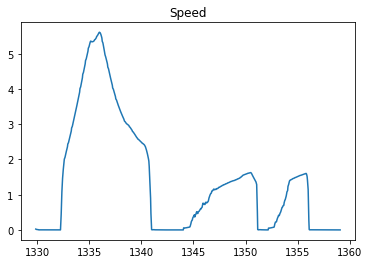

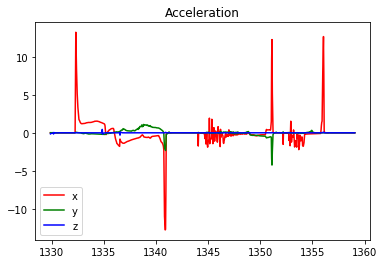

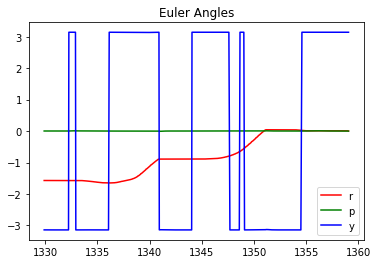

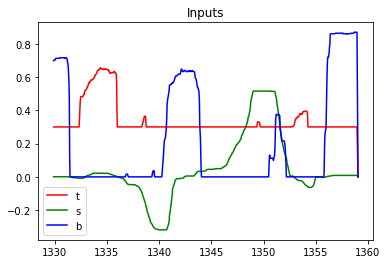

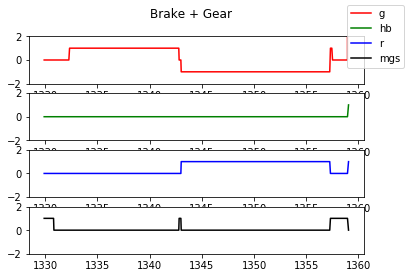

In [6]:
def extract_control_info(ctrl_list):
    ts = [];
    speeds = [];
    accs = [];
    oris = [];
    throttles = []; steers = []; brakes = []
    hand_brakes = []; reverses = []; gears = [];
    manual_gear_shifts = []
    
    for entry in ctrl_list:
        ts.append(entry['time'])
        speeds.append(entry['velocity'])
        accs.append(entry['acceleration'])
        oris.append(entry['orientation'])
        throttles.append(entry['throttle'])
        steers.append(entry['steer'])
        brakes.append(entry['brake'])
        hand_brakes.append(entry['hand_brake'])
        reverses.append(entry['reverse'])
        gears.append(entry['gear'])
        manual_gear_shifts.append(entry['manual_gear_shift'])
    
    ego_control_hist = {}
    ego_control_hist['t'] = np.array(ts)
    ego_control_hist['speed'] = np.array(speeds)
    ego_control_hist['acceleration'] = np.array(accs)
    ego_control_hist['orientation'] = np.array(oris)
    ego_control_hist['throttle'] = np.array(throttles)
    ego_control_hist['steer'] = np.array(steers)
    ego_control_hist['brake'] = np.array(brakes)
    ego_control_hist['gear'] = np.array(gears)
    ego_control_hist['hand_brakes'] = np.array(hand_brakes).astype(np.int)
    ego_control_hist['reverse'] = np.array(reverses).astype(np.int)
    ego_control_hist['manual_gear_shift'] = np.array(manual_gear_shifts).astype(np.int)
    
    return ego_control_hist

def plot_ego_control_hist(ego_ctrl_hist):
    #plt.subplot(511)
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['speed'])
    plt.title('Speed')
    plt.show()
    
    #plt.subplot(512)
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['acceleration'][:,0], 'r', label='x')
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['acceleration'][:,1], 'g', label='y')
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['acceleration'][:,2], 'b', label='z')
    plt.legend()
    plt.title('Acceleration')
    plt.show()
    
    #plt.subplot(513)
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['orientation'][:,0], 'r', label='r')
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['orientation'][:,1], 'g', label='p')
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['orientation'][:,2], 'b', label='y')
    plt.legend()
    plt.title('Euler Angles')
    plt.show()
    
    #plt.subplot(514)
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['throttle'], 'r', label='t')
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['steer'], 'g', label='s')
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['brake'], 'b', label='b')
    plt.legend()
    plt.title('Inputs')
    plt.show()
    
    plt.subplot(411)
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['gear'], 'r', label='g')
    plt.ylim([-2, 2])
    plt.subplot(412)
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['hand_brakes'], 'g', label='hb')
    plt.ylim([-2, 2])
    plt.subplot(413)
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['reverse'], 'b', label='r')
    plt.ylim([-2, 2])
    plt.subplot(414)
    plt.plot(ego_ctrl_hist['t'], ego_ctrl_hist['manual_gear_shift'], 'k', label='mgs')
    plt.figlegend()
    plt.ylim([-2, 2])
    plt.suptitle('Brake + Gear')
    plt.show()
    
ego_ctrl_hist = extract_control_info(res_dict['ego_control_list'])
plot_ego_control_hist(ego_ctrl_hist)

### Ego GPS Trace

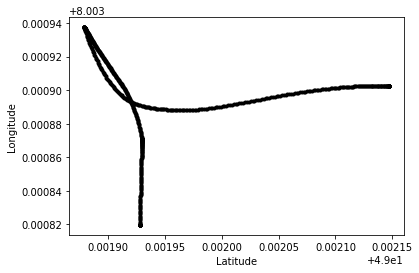

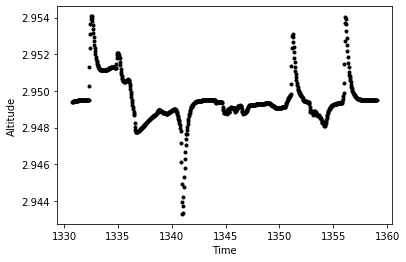

In [7]:
for entry in res_dict['ego_gps_list']:
    plt.figure(1)
    plt.plot(entry['latitude'], entry['longitude'], 'k.')
    plt.figure(2)
    plt.plot(entry['time'], entry['altitude'], 'k.')

plt.figure(1)
plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.figure(2)
plt.xlabel('Time')
plt.ylabel('Altitude')

plt.show()

In [8]:
res_dict['ego_odometry_list'][0]

{'time': 1329.956914717,
 'position': [285.0009765625, 239.99913024902344, 0.14481544494628906],
 'orientation': [-1.5707963267948966,
  0.0025683639985427257,
  -3.140902894867463],
 'linear_velocity': [0.00016972759976031248,
  -0.001972854345179208,
  0.013728861484321219],
 'angular_velocity': [-0.0008448919519982602,
  0.0033923603439011286,
  -6.414484966823784e-07]}

### Odometry

Text(0.5, 1.0, 'd/dt heading vs yawrate')

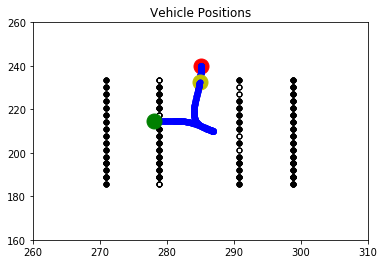

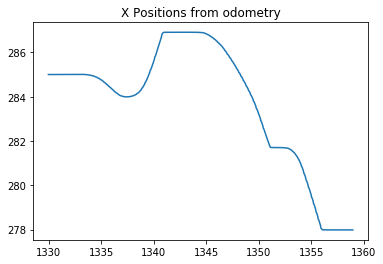

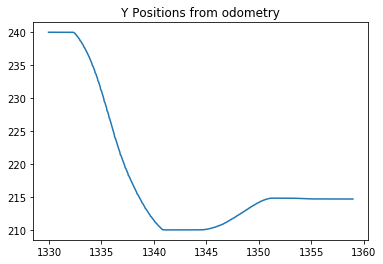

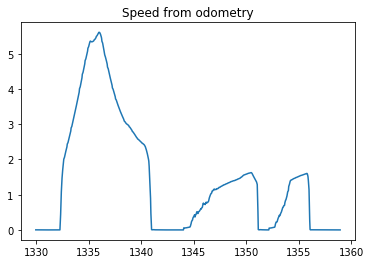

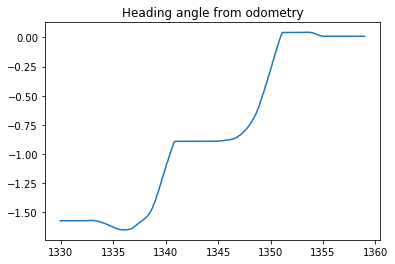

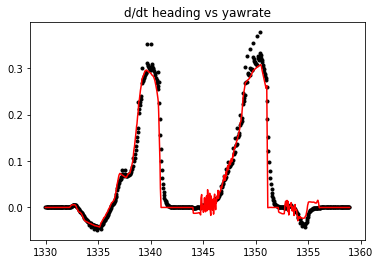

In [9]:
plt.figure(1)
spot_list_x = []
spot_list_y = []
for key in res_dict['vehicle_odometry_dict'].keys():
    position = res_dict['vehicle_odometry_dict'][key][0]['position']
    
    # Create all spots
    x, y = (round(position[0], 3), round(position[1], 3))
    if not x in spot_list_x: spot_list_x.append(x) 
    if not y in spot_list_y: spot_list_y.append(y)

# Plot all spots as empty circles
for spot_x in spot_list_x:
    for spot_y in spot_list_y:
        plt.plot(spot_x, spot_y, 'ko', fillstyle='none', markersize=5)

# Plot all occupied spots as filled circles
for key in res_dict['vehicle_odometry_dict'].keys():
    position = res_dict['vehicle_odometry_dict'][key][0]['position']
    plt.plot(position[0], position[1], 'ko', markersize=5)
    
ego_time = []
ego_x       = []
ego_y       = []
ego_v       = []
ego_heading = []
ego_yawrate = []

for i, entry in enumerate(res_dict['ego_odometry_list']):
    time = entry['time']
    position = entry['position']
    
    # Construct the value list
    ego_time.append(time)
    ego_x.append(position[0])
    ego_y.append(position[1])
    ego_v.append(np.sqrt(entry['linear_velocity'][0]**2 + entry['linear_velocity'][1]**2))
    ego_heading.append(entry['orientation'][0])
    ego_yawrate.append(entry['angular_velocity'][2])
    
    # Mark the intention
    if time in res_dict['intention_time_list']:
        plt.figure(1)
        plt.plot(position[0], position[1], 'yo', markersize=15)
    
    # Plot the trajectory
    if i == 0:
        plt.figure(1)
        plt.plot(position[0], position[1], 'ro', markersize=15)
    elif i == len(res_dict['ego_odometry_list'])-1:
        plt.figure(1)
        plt.plot(position[0], position[1], 'go', markersize=15)
    else:
        plt.figure(1)
        plt.plot(position[0], position[1], 'bo', markersize=5)
        
plt.figure(1)
plt.xlim([260, 310])
plt.ylim([160, 260])
plt.title('Vehicle Positions')

# Plot x, y, v, heading
plt.figure(2)
plt.plot(ego_time, ego_x)
# plt.xlim([260, 310])
# plt.ylim([160, 260])
plt.title('X Positions from odometry')

plt.figure(3)
plt.plot(ego_time, ego_y)
# plt.xlim([260, 310])
# plt.ylim([160, 260])
plt.title('Y Positions from odometry')

plt.figure(4)
plt.plot(ego_time, ego_v)
# plt.xlim([260, 310])
# plt.ylim([160, 260])
plt.title('Speed from odometry')

plt.figure(5)
plt.plot(ego_time, ego_heading)
# plt.xlim([260, 310])
# plt.ylim([160, 260])
plt.title('Heading angle from odometry')

def basic_lpf(noisy_signal, alpha=0.2):
    filt_signal = [noisy_signal[0]]
    for i in range(1, len(noisy_signal)):
        filt_val = alpha * noisy_signal[i] + (1 - alpha) * filt_signal[-1]
        filt_signal.append(filt_val)
    return filt_signal

plt.figure(6)
finite_diff = basic_lpf(np.diff(ego_heading) / np.diff(ego_time))
plt.plot(ego_time[:-1], finite_diff, 'k.')
plt.plot(ego_time, ego_yawrate, 'r')
plt.title('d/dt heading vs yawrate')

    

### Remaining Work

* [x] finish up odometry processing (e.g. velocities at least for ego)
* [x] fix weird final point (gear and position for last point is bad)
* [ ] Euler angle?

In [17]:
# TODO: consider using the object list in place of odometry
res_dict['vehicle_object_lists'][-5][-1]

{'time': 1358.823582889,
 'id': 1088,
 'detection_level': 0,
 'object_classified': True,
 'classification': 6,
 'classification_certainty': 1,
 'classification_age': 652,
 'position': [270.79998779296875, 185.5, 0.10131992399692535],
 'orientation': [0.0, 0.0, 3.141592653589793],
 'linear_velocity': [0.0, -0.0, 0.0],
 'angular_velocity': [0.0, -0.0, -0.0],
 'acceleration': [0.0, -0.0, 0.0],
 'shape_type': 1,
 'dimensions': (4.854057312011719, 2.0091400146484375, 1.6687989234924316)}